# Transfer learning

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix

import pdb
%matplotlib inline

In [18]:
device = torch.device('cuda:0')

In [19]:
from going_modular.going_modular import data_setup, engine, predictions
# source https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular

# Get Data

In [20]:
image_path = "Dataset\pizza_steak_sushi"
train_dir = image_path + "/train"
test_dir = image_path + "/test"

train_dir, test_dir

('Dataset\\pizza_steak_sushi/train', 'Dataset\\pizza_steak_sushi/test')

# Prepare images
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> 

In [21]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [22]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e7dae547f0>,
 ['pizza', 'steak', 'sushi'])

# Creating transfer models

In [23]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [24]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [25]:
# Create dataset uses auto_transform data
from going_modular.going_modular import data_setup, engine, predictions
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32
train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x1e7dae54940>,
 ['pizza', 'steak', 'sushi'])

In [26]:
 train_data,test_data = data_setup.create_ImageFolder(train_dir=train_dir,
                                                      test_dir=test_dir,
                                                      transform=auto_transforms)


In [27]:
# Set weights models
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [28]:
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
def summary_models(model):
    
    print(summary(model=model, 
            input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
            # col_names=["input_size"], # uncomment for smaller output
            col_names=["input_size", "output_size", "num_params", "trainable"],
            row_settings=["var_names"]
    ))
    

In [29]:
summary_models(model)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [30]:
# Замораживаем все слои для сохранения весовых коэффицентов модели
for param in model.features.parameters():
    param.requires_grad = False

In [31]:
output_shape = len(class_names)
output_shape

3

In [32]:
# Изменение выходного слоя модели под имеющиеся кол-во классов (3) (в блоке classifier слой Linear (out_features = кол-во классов))
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [33]:
summary_models(model)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

# Train transfer Model

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0903 | train_acc: 0.3867 | test_loss: 0.8477 | test_acc: 0.8040
Epoch: 2 | train_loss: 0.8431 | train_acc: 0.8242 | test_loss: 0.7674 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.7504 | train_acc: 0.8398 | test_loss: 0.7180 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7024 | train_acc: 0.7773 | test_loss: 0.6152 | test_acc: 0.8551
Epoch: 5 | train_loss: 0.6140 | train_acc: 0.8047 | test_loss: 0.6069 | test_acc: 0.8551
[INFO] Total training time: 44.229 seconds


# Plotting loss and acuracy 

In [36]:
from helper_functions import plot_loss_curves

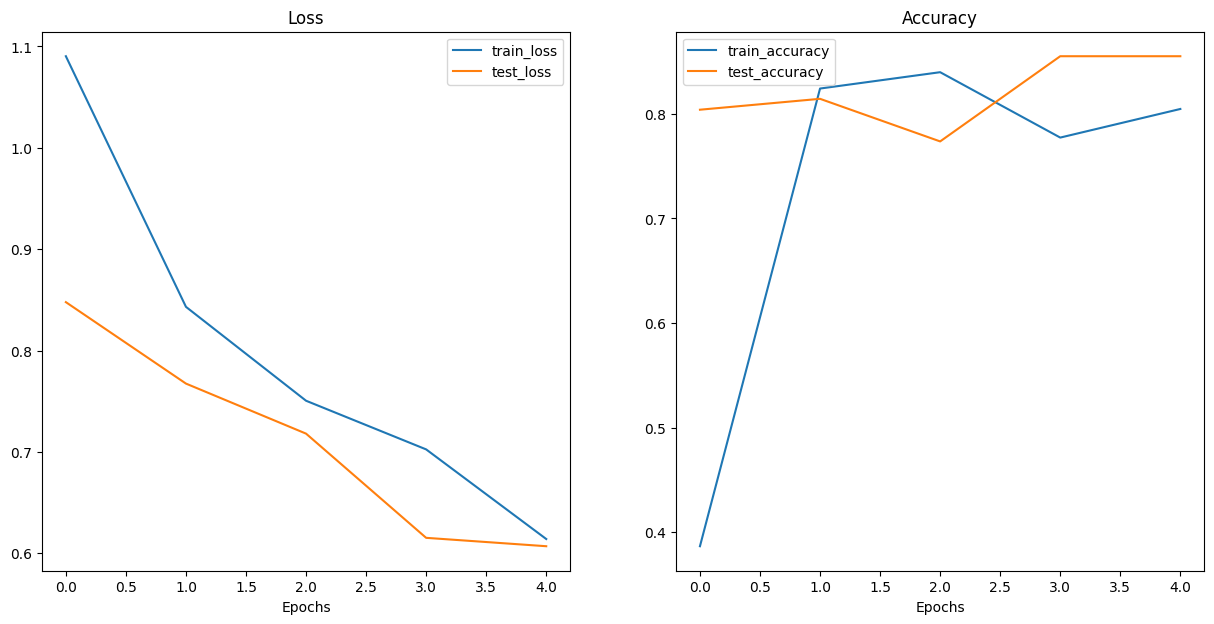

In [37]:
plot_loss_curves(results)

# Check Predict

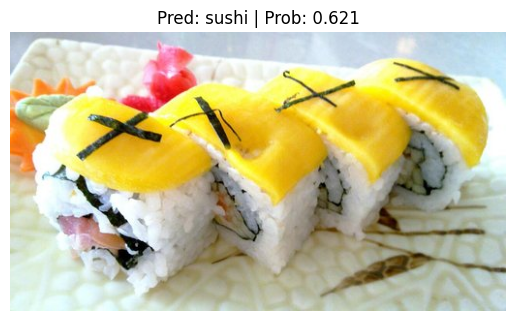

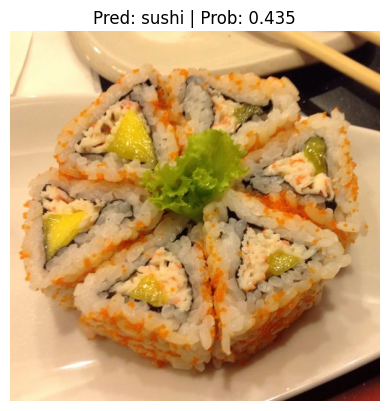

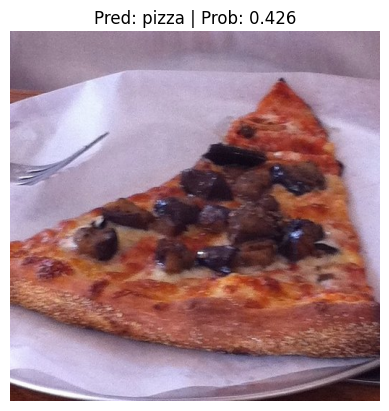

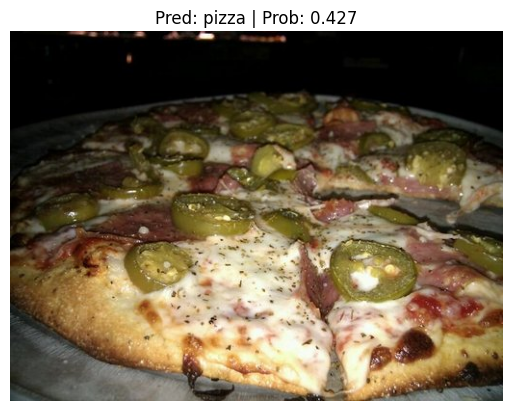

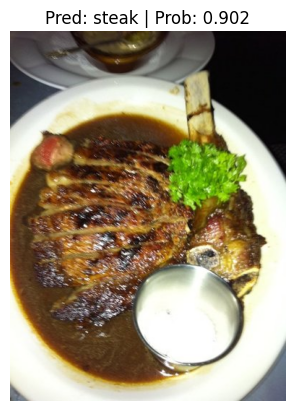

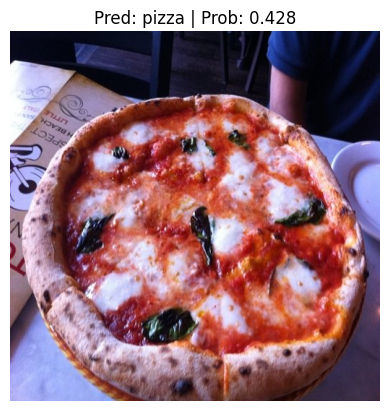

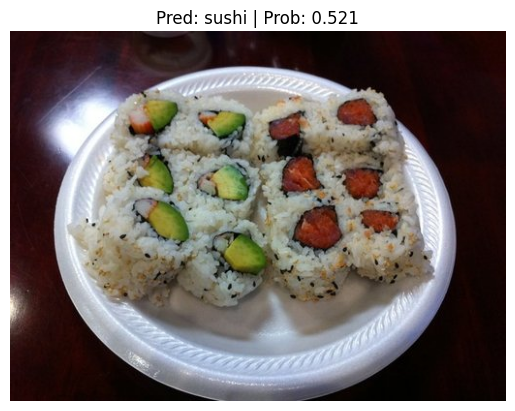

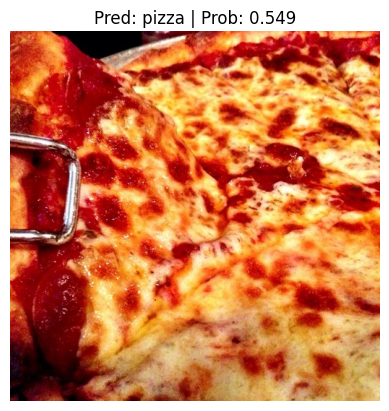

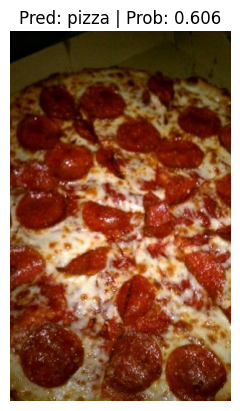

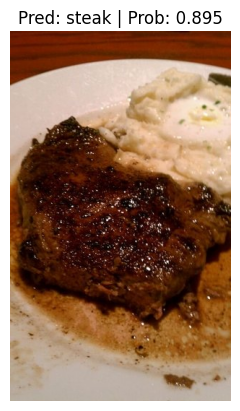

In [41]:
# Get a random list of image paths from test set
import random
from pathlib import Path
num_images_to_plot = 10
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    predictions.pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

In [64]:
from tqdm.auto import tqdm
y_preds = []
model.eval()
with torch.inference_mode(): # get predict data
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    x = X.unsqueeze(dim=0)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)





Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

<Axes: >

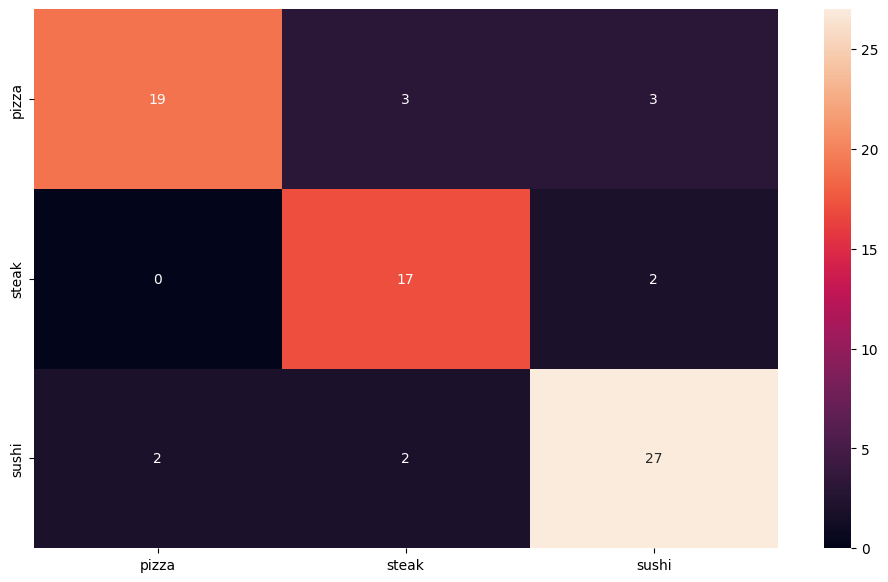

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
normalize = False
# iterate over test data
for inputs, labels in test_dataloader:
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) 

# constant for classes
classes = ('pizza', 'steak', 'sushi')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred_tensor)
if normalize:
    value = cf_matrix/np.sum(cf_matrix)
else:
    value = cf_matrix
    
df_cm = pd.DataFrame(value, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')
# Слева на право ->